In [1]:
import cv2
import os
import matplotlib.pyplot as plt
import numpy as np
from skimage.morphology import skeletonize
import itertools
from collections import defaultdict


In [2]:
IMG_PATH = "C:/programmering/DTU/robobot/data/blob/blob2.jpg"
CM_PATH = 'C:/programmering/DTU/robobot/config/camera/calibration_matrix.npy'
DIST_PATH = 'C:/programmering/DTU/robobot/config/camera/distortion_coefficients.npy'

In [3]:
mtx = np.load(CM_PATH)
dist = np.load(DIST_PATH)

In [4]:

def plot_mask(mask, title):
    if isinstance(mask, list):
        for i in range(len(mask)):
            plt.subplot(1, len(mask), i+1)
            plt.imshow(mask[i], cmap='gray')
            plt.title(title[i])
            plt.axis('off')
    else:
        plt.imshow(mask, cmap='gray')
        plt.title(title)
        plt.axis('off')
    plt.show()

In [5]:
def get_blue_mask(hsv):
    BLUE_MIN = np.array([100,90,0])
    BLUE_MAX = np.array([150,255,255])
    
    mask = cv2.inRange(hsv, BLUE_MIN, BLUE_MAX)
    
    mask = cv2.erode(mask, None, iterations=2)
    mask = cv2.dilate(mask, None, iterations=3)
    
    return mask

def get_orange_mask(hsv):
    
    ORANGE_MIN = np.array([0, 100, 0])
    ORANGE_MAX = np.array([12, 255, 255])
    mask = cv2.inRange(hsv, ORANGE_MIN, ORANGE_MAX)
    
    mask = cv2.erode(mask, None, iterations=3)
    mask = cv2.dilate(mask, None, iterations=2)
    return mask
    

def get_red_mask(hsv):
    # Adjusted RED_MIN and RED_MAX to cover the red hue range
    RED_MIN1 = np.array([0, 50, 50])  # Lower range of red
    RED_MAX1 = np.array([10, 255, 255])
    RED_MIN2 = np.array([170, 50, 50])  # Upper range of red
    RED_MAX2 = np.array([180, 255, 255])

    # Create masks for both red ranges and combine them
    mask1 = cv2.inRange(hsv, RED_MIN1, RED_MAX1)
    mask2 = cv2.inRange(hsv, RED_MIN2, RED_MAX2)
    mask = cv2.bitwise_or(mask1, mask2)
    
    mask = cv2.erode(mask, None, iterations=3)
    mask = cv2.dilate(mask, None, iterations=2)
    return mask

def get_white_mask(hsv):
    white_mask = cv2.inRange(hsv, (0, 0, 100), (180, 20, 255))
    # white_mask = cv2.erode(white_mask, None, iterations=5)
    # white_mask = cv2.dilate(white_mask, None, iterations=5)
    return white_mask

def get_color_mask(hsv):
    blue_mask = get_blue_mask(hsv)
    # white_mask = get_white_mask(hsv)
    red_mask = get_red_mask(hsv)
    orange_mask = get_orange_mask(hsv)

    mask = cv2.bitwise_or(blue_mask, red_mask)
    # mask = cv2.bitwise_or(mask, white_mask)
    mask = cv2.bitwise_or(mask, orange_mask)
    return mask
    
    
def filter_circles(circles):
    # Group overlapping circles
    circles_filtered = []
    for circle in circles[0, :]:
        x, y, r = circle.astype(float)
        # print("Examining:",x, y, r)

        overlap_found = False

        for c in circles_filtered:
            cx, cy, cr = c.astype(float)

            dist = np.sqrt((x - cx) ** 2 + (y - cy) ** 2)
            # print(x, cx, y, cy, r, cr, dist, cr + r, dist > cr + r)
            if dist < cr + r:
                overlap_found = True
                break
        if not overlap_found:
            circles_filtered.append(circle)
            
    return np.array(circles_filtered)

In [6]:

def detect_balls(image : np.ndarray, show : bool = False):
    """
    Detects Blue, White, Red and Orange ball objects given an image, and returns pixel position and radius.
    """
    
    hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

    n_balls = 6


    mask = get_color_mask(hsv_image)
    mask_applied = cv2.bitwise_and(image, image, mask=mask)
    
    # plot_mask(mask, ["Blue", "Red", "White", "Orange"])
    # plot_mask(cv2.cvtColor(mask_applied, cv2.COLOR_BGR2RGB) , ["Blue", "Red", "White", "Orange"])

    
    gray = cv2.cvtColor(mask_applied, cv2.COLOR_BGR2GRAY)

    #Blur
    gray_blurred = cv2.GaussianBlur(gray, (9, 9), 2)

    #Find Circles
    circles = cv2.HoughCircles(
        gray_blurred,
        cv2.HOUGH_GRADIENT,
        dp=1.2,
        minDist=1,
        param1=50,
        param2=25,  # The smaller it is, the more false circles may be detected. Circles, corresponding to the larger accumulator values, will be returned first.
        minRadius=5,
        maxRadius=50,
    )

    circles_filtered = None
    if circles is not None:
        circles = np.uint16(np.around(circles))
        circles_filtered = filter_circles(circles)
                
        if show:
            for circle in circles_filtered:
                x, y, r = circle
                cv2.circle(image, (x, y), r, (170, 0, 255), 10)
                cv2.circle(image, (x, y), 2, (0, 0, 0), 20)

    if show:
        plt.figure(figsize=(10, 10))
        plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        plt.title("Detected Circles")
        plt.axis("off")
        plt.show()
    
    return circles_filtered



#     break # only draw the best circle

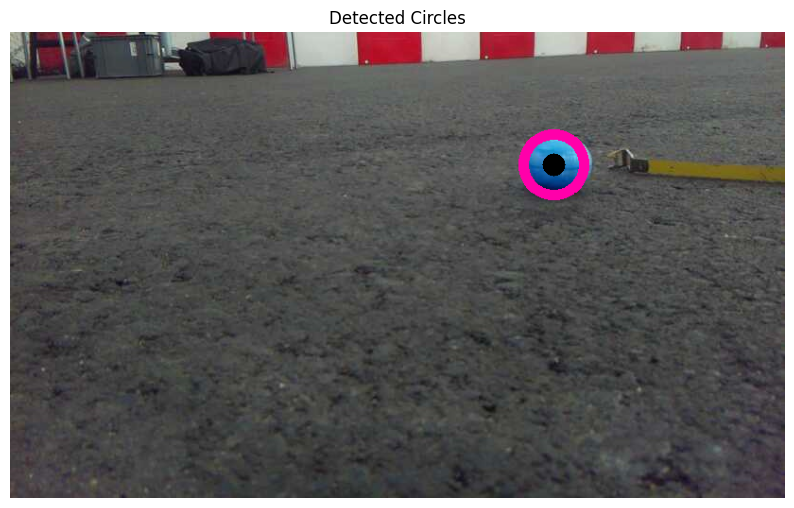

Detected circles: [[575 140  32]]
[ 0.2596775  -0.27441946  1.        ]
[ 0.11745659 -0.12412463  0.45231715]


In [7]:
# image = cv2.imread("../data/blob/robobot/image_2025_Mar_28_162150_009.jpg")
image = cv2.imread("C:/Users/marku/Downloads/159016cb-39c7-473a-9487-43dcc69a5e34.jpg")
# Crop image to remove the top 45% part of the image
image = image[int(image.shape[0]*0.2):, :]
detections = detect_balls(image, show=True)
# 
print("Detected circles:", detections)



detection = detections[0]

def pose_estimation_ball(detection, mtx, dist):
    """
    Estimate the pose of a ball given its detection in the image.
    """
    x, y, r = detection
    cam_pos = np.array([x, y, 1])
    
    # Invert the camera matrix
    mtx_inv = np.linalg.inv(mtx)
    
    # Normalize the camera position using the inverse camera matrix
    cam_pos_normalized = np.dot(mtx_inv, cam_pos)
    Z = (mtx[0,0] * 45/2 / 1000) / r # 45 cm is the distance to the camera in meters
    return cam_pos_normalized * Z

x, y, r = detection

cam_pos = np.array([x, y, 1])

mtx_inv = np.linalg.inv(mtx)
cam_pos_normalized = np.dot(mtx_inv, cam_pos)

Z = (mtx[0,0] * 45/2 / 1000) / r # 45 cm is the distance to the camera in meters

print(cam_pos_normalized)

print(cam_pos_normalized * Z)

In [8]:
# IMG_DIR = "C:/programmering/DTU/robobot/data/blob/robobot"
# images_path = os.listdir(IMG_DIR)

# for image_name in images_path:
#     image = cv2.imread(os.path.join(IMG_DIR, image_name))
#     image = image[int(image.shape[0]*0.45):, :] #Remove top 45% of the image
    
#     circles = detect_balls(image, show=True)
#     if circles is not None:
#         print(f"Image: {image_name}, Circles detected: {len(circles)}")
#     else:
#         print(f"Image: {image_name}, No circles detected")

